# project notebook

## table of contents:

###  [1. collect reddit data ](#section_1)

###  [2. collect stock price data](#section_2)

### [3. analyze](#section_3)

### [4. predict](#section_4)

### [5. conclusion](#section_5)

In [14]:
%matplotlib inline

<a id='section_1'></a>

# 1. collect reddit data

## 1.1 get credentials

In [1]:
import yaml

global client_id
global secret
global developers
global password

with open("config.yml", 'r') as configfile:
    cfg = yaml.load(configfile)

client_id = cfg['reddit_credentials']['client_id']
secret = cfg['reddit_credentials']['secret']
developers = cfg['reddit_credentials']['developers']
password = cfg['reddit_credentials']['password']

## 1.2 fetch data from reddit

### create connection and test

In [181]:
import praw

reddit = praw.Reddit(client_id=client_id,
                     client_secret= secret, password=password,
                     user_agent='agent', username=developers)

In [3]:
subreddit = reddit.subreddit('technology')

hot_subs = subreddit.hot(limit = 3)

for submission in hot_subs:
    print(submission.title)

Any form of threatening, harassing, or violence / physical harm towards anyone will result in a ban
Got a tech question or want to discuss tech? Weekly /r/Technology Tech Support / General Discussion Thread
America desperately needs fiber internet, and the tech giants won’t save us - Harvard’s Susan Crawford explains why we shouldn’t expect Google to fix slow internet speeds in the US.


In [4]:
submission = reddit.submission(id='9jdami')

In [5]:
for top_level_comment in submission.comments:
    print(top_level_comment.body)

Pretty soon they are gonna need to start storing unsold graphics cards inside of Fort Knox based on their pricing rise.
Would this impact existing products? I was considering picking up a 1080ti after the 2080ti has been down for a while but don't want it to cost more than it does now.
The reason why the 2080ti is  priced at 1000 finally made clear.
We live in a society.
Or they can always make it in a non-tariff country.
Nah they just need to engage contract manufacturers in Taiwan or elsewhere.  Or ship parts from China and assemble in Malaysia, or..... so many other ways to get around the tarriff. 
As the prices of all consumer goods rise, retailers need to start putting big bold stickers on products that cost way more "Price increase due to Donald Trump's trade tariffs."
God damn it, I need an upgrade for my graphics card. Sucks using a 960 still :c
Imma get that geforce graphics card before the end of this year!
They should just "bundle" the cards in cheap towers or cases. 
Would 

### util functions

In [2]:
def get_sub_comments(comment, allComments, verbose=True):
    allComments.append(comment)
    if not hasattr(comment, "replies"):
        replies = comment.comments()
        if verbose: print("fetching (" + str(len(allComments)) + " comments fetched total)")
    else:
        replies = comment.replies
    for child in replies:
        get_sub_comments(child, allComments, verbose=verbose)
    


def get_all_comments(r, submissionId, verbose=True):
    # r is reddit client
    submission = r.submission(submissionId)
    comments = submission.comments
    commentsList = []
    for comment in comments:
        if not isinstance(comment, praw.models.MoreComments):
            get_sub_comments(comment, commentsList, verbose=verbose)
    return commentsList


In [3]:
from datetime import datetime, timedelta

def utc_to_datetime(sec):
    utc_date = datetime(1970, 1, 1, 0, 0, 0)
    date =  utc_date+ timedelta(seconds=sec)
    return date

In [183]:
def submission_to_json(sub):
    json = {}
    json['_id'] = sub.id
    json['title'] = sub.title
    json['author'] = str(sub.author)
    json['date'] = utc_to_datetime(sub.created_utc)
    json['num_comments'] = sub.num_comments
    json['permalink']= sub.permalink
    json['score'] = sub.score
    json['stickied'] = sub.stickied
    json['upvote_ratio'] = sub.upvote_ratio
    return json


def comment_to_json(comment):
    json = {}
    json['_id'] = comment.id
    try:
        json['author'] = str(comment.author)
    except:
        print comment.id
        pass
    json['date'] = utc_to_datetime(comment.created_utc)
    json['body'] = comment.body
    json['link_id'] = comment.link_id
    json['parent_id'] = comment.parent_id
    json['score'] = comment.score
    return json
    

def write_to_mongo(json, collection):
    try:
        collection.insert_one(json)
    except pymongo.errors.DuplicateKeyError:
        _id = json['_id']
        collection.update_one({ "_id": _id }, {'$set': json})
    except Exception as e:
        print e
        
        

## 1.3 setup mongo

In [179]:
import pymongo
from pymongo import IndexModel, ASCENDING, DESCENDING
from pymongo import MongoClient

mongo = MongoClient('localhost', 27017)
#amd_db = mongo['amd']
#amd_sub = amd_db['submissions']
#amd_com = amd_db['comments']
intel_db = mongo['intel']
intel_sub = intel_db['submissions']
intel_com = intel_db['comments']


# create index in mongodb - date, submission id
#date_index = IndexModel([('date', DESCENDING)])
#subid_index = IndexModel([('parent_id', ASCENDING)])
#amd_com.create_indexes([date_index, subid_index])
#amd_sub.create_indexes([date_index])

## 1.4 fetch from reddit and write to mongodb

In [189]:
def fetch_from_reddit(search_term, db, sub_col, com_col, reddit_conn, subreddit_name = 'technology'):
    subreddit = reddit_conn.subreddit(subreddit_name)
    stock_submissions = subreddit.search(search_term, limit=None)
    
    for submission in stock_submissions:
        sub_json = submission_to_json(submission)
        write_to_mongo(sub_json, sub_col)
        print 'processed submission: ', submission.id
        # get all comments and filter out ones that are not comments
        comments = filter(lambda elm: isinstance(elm, praw.models.Comment), 
                          get_all_comments(reddit_conn, submission.id))
        for comment in comments:
            com_json = comment_to_json(comment)
            write_to_mongo(com_json, com_col)

In [191]:
fetch_from_reddit('Intel', intel_db, intel_sub, intel_com, reddit)

processed submission:  ageqcj
processed submission:  adowzp
processed submission:  9tp7k7
processed submission:  a2em15
processed submission:  adrrwf
processed submission:  agtryv
processed submission:  9qdhd4
processed submission:  9113hs
fetching (10 comments fetched total)
fetching (12 comments fetched total)
fetching (17 comments fetched total)
fetching (20 comments fetched total)
fetching (34 comments fetched total)
fetching (50 comments fetched total)
fetching (54 comments fetched total)
fetching (61 comments fetched total)
fetching (65 comments fetched total)
fetching (73 comments fetched total)
fetching (75 comments fetched total)
fetching (77 comments fetched total)
fetching (80 comments fetched total)
fetching (84 comments fetched total)
fetching (87 comments fetched total)
fetching (97 comments fetched total)
fetching (105 comments fetched total)
fetching (110 comments fetched total)
fetching (114 comments fetched total)
fetching (148 comments fetched total)
fetching (150 co

In [14]:


subreddit = reddit.subreddit('technology')

amd_submissions = subreddit.search(stock_name, limit=None)

for submission in amd_submissions:
    sub_json = submission_to_json(submission)
    write_to_mongo(sub_json, amd_sub)
    print 'processed submission: ', submission.id
    # get all comments and filter out ones that are not comments
    comments = filter(lambda elm: isinstance(elm, praw.models.Comment), get_all_comments(reddit, submission.id))
    for comment in comments:
        com_json = comment_to_json(comment)
        write_to_mongo(com_json, amd_com)
    

processed submission:  ae7v4c
processed submission:  a3os5s
processed submission:  abvmes
processed submission:  adbtcc
processed submission:  aedt7b
processed submission:  aecr1q


KeyboardInterrupt: 

<a id='section_2'></a>

# 2. collect stock price data

## 2.1 fetch data from api

In [193]:
import pyEX

amd_stock = pyEX.chartDF('AMD', timeframe='1y')
# amd_stock.to_csv('amd_stock_prices.csv', sep=',')

In [398]:
amd_stock.to_pickle("amd_stock.pkl")

In [18]:
amd_stock.head()

,change,changeOverTime,changePercent,close,high,label,low,open,unadjustedVolume,volume,vwap
date,,,,,,,,,,,
2018-01-09,-0.46,0.000000,-3.746,11.82,12.02,"Jan 9, 18",11.7100,12.00,62560940,62560940,11.8352
2018-01-10,0.14,0.011844,1.184,11.96,12.15,"Jan 10, 18",11.5600,11.63,52561170,52561170,11.9878
2018-01-11,0.18,0.027073,1.505,12.14,12.19,"Jan 11, 18",11.9001,12.07,38354916,38354916,12.1005
2018-01-12,-0.12,0.016920,-0.988,12.02,12.07,"Jan 12, 18",11.8000,11.82,47149344,47149344,11.9331
2018-01-16,-0.11,0.007614,-0.915,11.91,12.20,"Jan 16, 18",11.8000,12.05,42686623,42686623,12.0251


In [194]:
import pyEX

intel_stock = pyEX.chartDF('INTC', timeframe='1y')

In [195]:
intel_stock.to_pickle('intel_stock.pkl')

In [196]:
intel_stock.head()

,change,changeOverTime,changePercent,close,high,label,low,open,unadjustedVolume,volume,vwap
date,,,,,,,,,,,
2018-01-29,-0.097545,0.000000,-0.200,48.7531,49.6018,"Jan 29, 18",48.1581,48.3825,46304040,46304040,48.9428
2018-01-30,-1.160800,-0.023808,-2.381,47.5924,48.8312,"Jan 30, 18",47.5436,48.2654,32814590,32814590,48.0278
2018-01-31,-0.634044,-0.036814,-1.332,46.9583,48.0411,"Jan 31, 18",46.3925,48.0215,41619914,41619914,46.9307
2018-02-01,-0.477971,-0.046619,-1.018,46.4803,47.2802,"Feb 1, 18",46.2852,46.5242,28840380,28840380,46.6787
2018-02-02,-1.463200,-0.076629,-3.148,45.0172,46.6169,"Feb 2, 18",44.9684,46.1584,28663029,28663029,45.6670


<a id='section_3'></a>

# 3. analyze

## 3.1 compute polarity

In [6]:
import pandas as pd
from textblob import TextBlob

def get_stock_price(picklename, start_date, end_date):
    # outputs df with date and close price
    # ex. start_date ='2018-11-05'= end_date, returns stock price for 2018-11-05
    df = pd.read_pickle(picklename)
    #df.index = pd.to_datetime(df.index)
    df = df.loc[(df.index >= start_date) & (df.index <= end_date)]['close']
    return df
    
    
def get_comments_by_date(col, start_date, end_date):
    # col is the collection, ex. amd_com
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    date_comm = {}
    date_score = {} # total score by date
    
    for doc in col.find({'date': {'$gte': start, '$lte': end}},{'body':1, 'date':1, 'score':1, '_id':0}):
        date = doc['date'].date()
        if date in date_comm:
            date_comm[date] += doc['body']
            date_score[date] += doc['score']
        else:
            date_comm[date] = doc['body']
            date_score[date] = doc['score']
    return date_comm, date_score


def get_submissions_by_date(col, start_date, end_date):
    # col is the collection, ex. amd_com
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    date_comm = {}
    date_score = {} # total score by date
    
    for doc in col.find({'date': {'$gte': start, '$lte': end}},{'title':1, 'date':1, 'score':1, '_id':0}):
        date = doc['date'].date()
        if date in date_comm:
            date_comm[date] += doc['title']
            date_score[date] += doc['score']
        else:
            date_comm[date] = doc['title']
            date_score[date] = doc['score']
    return date_comm, date_score


def get_polarity(dic_or_df):
    if isinstance(dic_or_df, dict):
        df = pd.DataFrame.from_dict(dic_or_df, orient='index').rename(columns={0:'text'})
    else:
        df = dic_or_df
    try:
        df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment[0])
    except UnicodeDecodeError:
        df['polarity'] = df['text'].str.decode('utf-8').apply(lambda x: TextBlob(x).sentiment[0])
    return df


def get_scores(dic):
    df = pd.DataFrame.from_dict(dic, orient='index').rename(columns={0:'score'})
    return df


def fill_dates(df, start_date, end_date, fill_value):
    # start date and end date are strings
    idx = pd.date_range(start_date, end_date)
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=fill_value)
    return df 

def fill_stock_price(df, start_date, end_date):
    # fill-in weekend prices as the previous friday's price
    idx = pd.date_range(start_date, end_date)
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=None)
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    return df

Get Reddit comments

In [13]:
amd_comm, amd_score = get_comments_by_date(amd_com, '2018-01-01', '2018-10-27')

amd_comm_df = get_polarity(amd_comm)

amd_comm_df.head(n=3)

,text,polarity
2018-02-13,"I don't read that article, but saw few videos ...",0.32500
2018-05-06,It looks like AMD might just be trying to prot...,0.04375
2018-07-31,Last Card to smack Nvidia was the 7970 which t...,0.31000


## 3.2 plot comment polarity

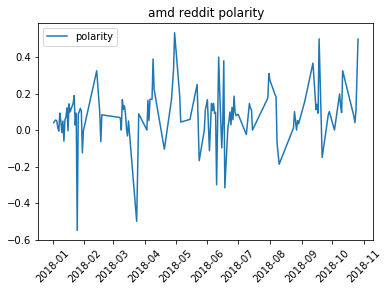

In [10]:
%matplotlib inline

amd_comm_df.plot(y='polarity', use_index=True, title = 'amd reddit polarity', rot = 45)

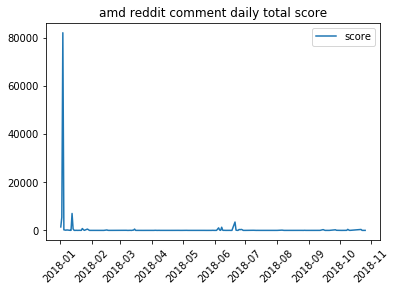

In [30]:
get_scores(amd_score).plot(use_index=True, title = 'amd reddit comment daily total score', rot = 45)

## 3.3 plot stock prices

In [16]:
amd_stock = get_stock_price('amd_stock.pkl', '2018-01-01', '2018-10-27')

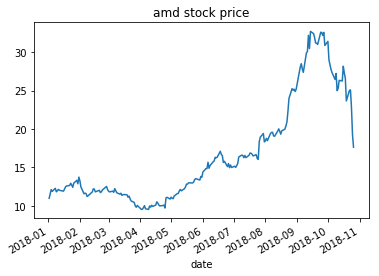

In [23]:
amd_stock.plot(title = 'amd stock price')

In [24]:
amd_comm_df = fill_dates(amd_comm_df,'2018-01-01', '2018-10-27',0 )

## 3.4 comment polarity and stock price

In [12]:
import matplotlib.pyplot as plt 

def plot_polarity_price(series1, series2, label1, label2, xlabel, figsize=(12,5)):
    plt.figure(figsize=(12,5))
    plt.xlabel(xlabel)

    ax1 = series1.plot(color='blue', grid=True, label=label1)
    ax2 = series2.plot(color='red', grid=True, secondary_y=True, label=label2)

    ax1.legend(loc=1)
    ax2.legend(loc=2)

    plt.show()

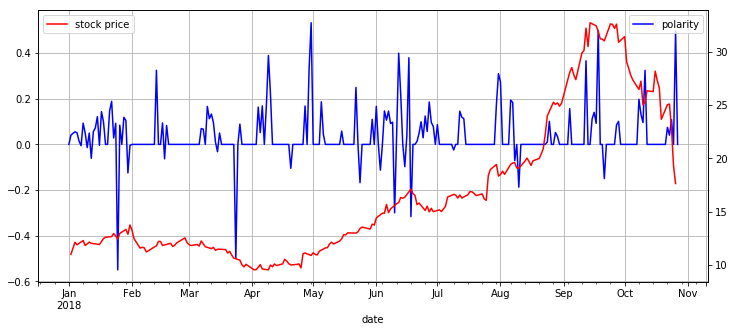

In [26]:
plot_polarity_price(amd_comm_df['polarity'], amd_stock, 'polarity', 'stock price', 'Date')

## 3.5 submission polarity and stock price

In [9]:
amd_submissions, amd_sub_score = get_submissions_by_date(amd_sub, '2018-01-01', '2018-10-27')

amd_sub_df = get_polarity(amd_submissions)

In [10]:
amd_sub_df = fill_dates(amd_sub_df, '2018-01-01', '2018-10-27',0)

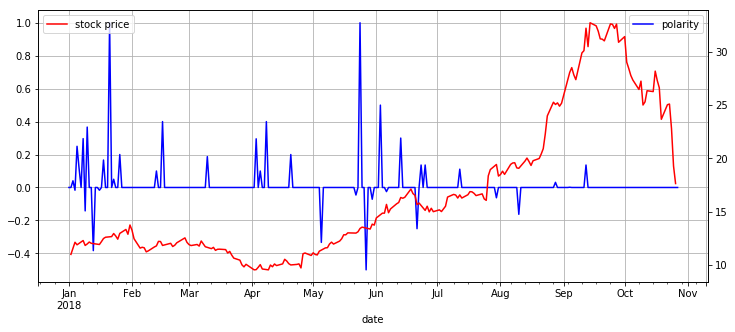

In [17]:
plot_polarity_price(amd_sub_df['polarity'], amd_stock, 'polarity', 'stock price', 'Date')

## 3.6 submission & comments polarity vs. stock price

In [ ]:
amd_sub_comm_df = (amd_sub_df['text'].str.encode('utf-8').fillna(value=' ')\
    +amd_comm_df['text'].str.encode('utf-8').fillna(value= ' ')).to_frame()
    
amd_sub_comm_df = get_polarity(amd_sub_comm_df)


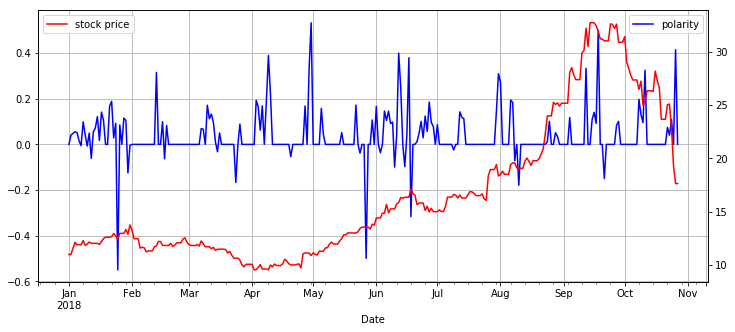

In [647]:
plot_polarity_price(amd_sub_comm_df['polarity'], amd_stock, 'polarity', 'stock price', 'Date')

## 3.7 rolling average

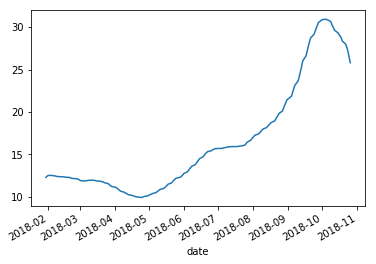

In [486]:
amd_stock.rolling(window=20).mean().plot()

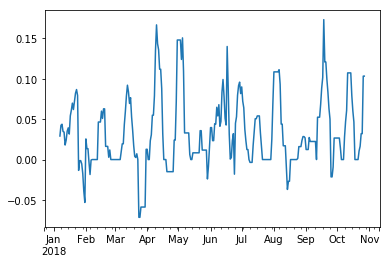

In [496]:
amd_comm_df['polarity'].rolling(window=7).mean().plot()

## 3.8 cross correlation

In [527]:
amd_stock = fill_stock_price(amd_stock, '2018-01-01', '2018-10-27')

In [653]:
import numpy as np
import matplotlib.pyplot as plt

def plot_compute_corr(series1, series2):
    corr = np.correlate(np.asarray(series1),np.asarray(series2),'full')
    plt.plot(corr)

    print 'corr: ', np.argmax(corr)
    print 'days lag: ', np.argmax(corr)-len(series1)

corr:  301
days lag:  1


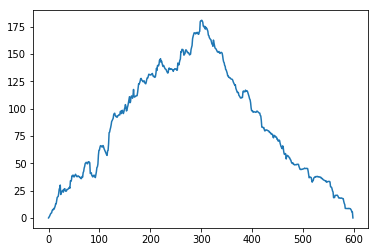

In [655]:
plot_compute_corr(amd_comm_df['polarity'], amd_stock)

corr:  184
days lag:  -116


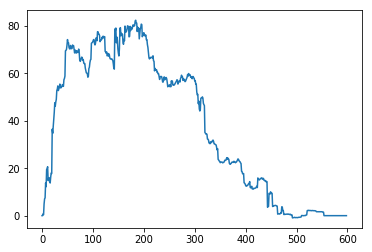

In [656]:
plot_compute_corr(amd_sub_df['polarity'], amd_stock)

corr:  301
days lag:  1


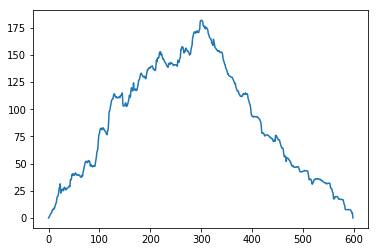

In [657]:
plot_compute_corr(amd_sub_comm_df['polarity'], amd_stock)

<a id='section_4'></a>

## 3.9 delta price vs. polarity ---- run below sections for analysis in 3.9

### 3.9.1 same day polarity

In [59]:
def get_stock_delta_price(picklename, start_date, end_date):
    # outputs df with date and close price
    # ex. start_date ='2018-11-05'= end_date, returns stock price for 2018-11-05
    df = pd.read_pickle(picklename)
    #df.index = pd.to_datetime(df.index)
    df = df.loc[(df.index >= start_date) & (df.index <= end_date)]['change']
    return df

In [60]:
amd_submissions, amd_sub_score = get_submissions_by_date(amd_sub, '2018-01-01', '2018-10-27')
amd_sub_df = get_polarity(amd_submissions)
amd_sub_df['polarity'].head()

2018-04-08    0.400000
2018-06-23    0.136364
2018-01-08    0.296591
2018-02-16    0.400000
2018-04-27    0.000000
Name: polarity, dtype: float64

In [61]:
amd_delta_price = get_stock_delta_price('amd_stock.pkl', '2018-01-01', '2018-10-27')

In [62]:
amd_delta_price.shape

(208,)

In [63]:
amd_sub_df.shape

(71, 2)

In [65]:
deltap_pol = pd.concat([amd_delta_price, amd_sub_df['polarity']], axis=1)

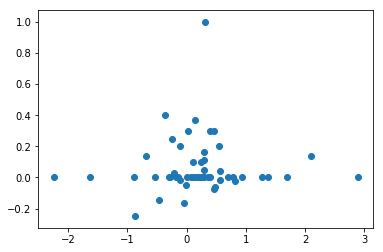

In [66]:
plt.scatter(deltap_pol['change'], deltap_pol['polarity'])

### 3.9.2 different day polarity

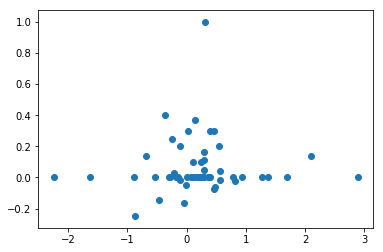

In [73]:
# function to shift dates
# can use 'shift' function
import time

new_date_index = date_index.shift(2, freq='D')
temp_pol = amd_sub_df['polarity']
new_temp_pol = temp_pol.reindex(new_date_index)
# combine with price df
deltap_pol = pd.concat([amd_delta_price, new_temp_pol], axis=1)['change']
plt.scatter(deltap_pol['change'], deltap_pol['polarity'])


In [214]:
def plot_days_shift(delta_price, polarity, days_low=1, days_high=31):
    days_shift = range(days_low, days_high)
    date_index = pd.DatetimeIndex(polarity.index)
    for i in days_shift:
        new_date_index = date_index.shift(i, freq='D')
        temp_pol = polarity
        new_temp_pol = temp_pol.reindex(new_date_index)
        # combine with price df
        deltap_pol = pd.concat([delta_price, new_temp_pol], axis=1)
        print 'days shifted: ', i,  ' number of data points:', deltap_pol.dropna().shape[0]
        plt.subplot(6,5,i)
        plt.scatter(deltap_pol.iloc[:,0], deltap_pol.iloc[:,1])


### 3.9.2 amd: shift in days 

days shifted:  1  number of data points: 18
days shifted:  2  number of data points: 19
days shifted:  3  number of data points: 15
days shifted:  4  number of data points: 11
days shifted:  5  number of data points: 13
days shifted:  6  number of data points: 12
days shifted:  7  number of data points: 15
days shifted:  8  number of data points: 15
days shifted:  9  number of data points: 10
days shifted:  10  number of data points: 13
days shifted:  11  number of data points: 9
days shifted:  12  number of data points: 15
days shifted:  13  number of data points: 12
days shifted:  14  number of data points: 12
days shifted:  15  number of data points: 14
days shifted:  16  number of data points: 10
days shifted:  17  number of data points: 12
days shifted:  18  number of data points: 12
days shifted:  19  number of data points: 10
days shifted:  20  number of data points: 7
days shifted:  21  number of data points: 16
days shifted:  22  number of data points: 12
days shifted:  23  nu

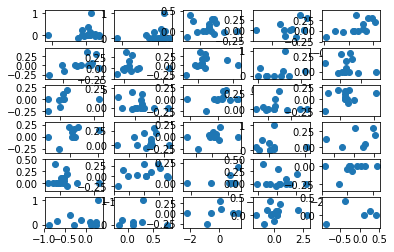

In [215]:
amd_submissions, amd_sub_score = get_submissions_by_date(amd_sub, '2018-01-01', '2018-10-27')
amd_sub_df = get_polarity(amd_submissions)

amd_delta_price = get_stock_delta_price('amd_stock.pkl', '2018-01-01', '2018-10-27')
plot_days_shift(amd_delta_price, amd_sub_df['polarity'])

### 3.9.3 Moving average

- creates a time series of values calculated based on previous x days' average
- this is done to obtain more data points so that our result may be more significant

In [159]:
# polarity and price series
amd_submissions, amd_sub_score = get_submissions_by_date(amd_sub, '2018-01-01', '2018-10-27')
amd_sub_df = get_polarity(amd_submissions)
amd_pol = amd_sub_df['polarity'].sort_index()
amd_delta_price = get_stock_delta_price('amd_stock.pkl', '2018-01-01', '2018-10-27')

In [135]:
def moving_avg(series, n):
    new_series = pd.DataFrame(np.convolve(series, np.ones((n,))/n, mode = 'valid'))
    new_index = pd.DatetimeIndex(series.index[n-1:])
    #new_series.reindex(new_index)
    new_series.index = new_index
    return new_series

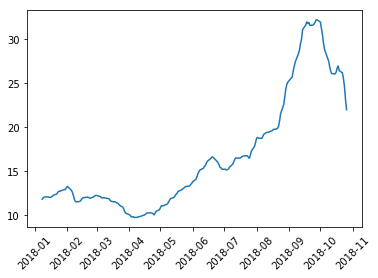

In [136]:
import numpy as np
plt.xticks(rotation=45)
plt.plot(moving_avg(amd_price, 5))

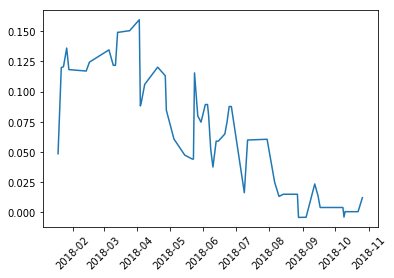

In [154]:
# moving average of polarity
# amd_pol
import numpy as np
plt.xticks(rotation=45)
plt.plot(moving_avg(amd_pol, 14).index, moving_avg(amd_pol, 14))
#plt.scatter(moving_avg(amd_pol, 5).index, moving_avg(amd_pol, 5))

### 3.9.4 Moving avg and Diff Day

### 3.9.4 amd: shift in days of moving avg

days shifted:  1  number of data points: 9
days shifted:  2  number of data points: 12
days shifted:  3  number of data points: 9
days shifted:  4  number of data points: 7
days shifted:  5  number of data points: 7
days shifted:  6  number of data points: 5
days shifted:  7  number of data points: 8
days shifted:  8  number of data points: 9
days shifted:  9  number of data points: 6
days shifted:  10  number of data points: 9
days shifted:  11  number of data points: 6
days shifted:  12  number of data points: 11
days shifted:  13  number of data points: 7
days shifted:  14  number of data points: 8
days shifted:  15  number of data points: 10
days shifted:  16  number of data points: 8
days shifted:  17  number of data points: 10
days shifted:  18  number of data points: 10
days shifted:  19  number of data points: 9
days shifted:  20  number of data points: 5
days shifted:  21  number of data points: 14
days shifted:  22  number of data points: 11
days shifted:  23  number of data 

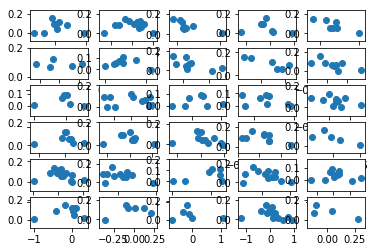

In [216]:
plot_days_shift(moving_avg(amd_delta_price, 5), moving_avg(amd_pol, 14), days_low=1, days_high=31)

### 3.9.5 Simple regression and R^2

In [205]:
# calculate R^2 for all day shifts
import numpy as np
from sklearn.linear_model import LinearRegression

def get_r2(delta_price, polarity, days_low=1, days_high=31):
    days_shift = range(days_low, days_high)
    date_index = pd.DatetimeIndex(polarity.index)
    for i in days_shift:
        new_date_index = date_index.shift(i, freq='D')
        temp_pol = polarity
        new_temp_pol = temp_pol.reindex(new_date_index)
        deltap_pol = pd.concat([delta_price, new_temp_pol], axis=1).dropna()
        shape = deltap_pol.iloc[:,0].shape[0]
        X = np.reshape(deltap_pol.iloc[:,0], (shape, 1))
        Y = np.reshape(deltap_pol.iloc[:,1], (shape, 1))
        
        #print X.shape, Y.shape
        reg = LinearRegression().fit(X,Y )
        print i, reg.score(X, Y)

get_r2(moving_avg(amd_delta_price, 5), moving_avg(amd_pol, 14), days_high = 60)

1 0.00127359870828
2 9.28479004523e-05
3 0.554907107408
4 0.0616796754659
5 0.689090101469
6 0.00602266351855
7 0.0496799117798
8 0.417777179245
9 0.73152905511
10 0.461086451892
11 0.00314641715016
12 0.000530380484312
13 0.0282142147841
14 0.157129808873
15 0.229228036525
16 0.0102973959259
17 0.00688411328335
18 0.0476187213121
19 0.312473313404
20 0.584833434703
21 0.0622935291153
22 0.110798279945
23 0.310465327539
24 0.0892866559545
25 0.000806553210945
26 0.109944097138
27 0.166527437199
28 0.0384638736684
29 0.0964919333189
30 0.595920693692
31 0.29278601071
32 0.0500532652988
33 0.143515547273
34 0.000656478159268
35 0.12395556972
36 0.0219545208365
37 0.0755155958484
38 1.0
39 0.165288192205
40 0.410608956288
41 0.373828496548
42 0.0210022278644
43 0.00444862279409
44 0.0289724753082
45 0.126134148651
46 0.124596201524
47 0.0794587633865
48 0.065997105204
49 0.486430406722
50 0.397687172501
51 0.137484897666
52 0.0313984925751
53 0.722775618637
54 0.087307485733
55 0.06198195

### 3.9.6 Intel (submission polarity)

In [220]:
intel_delta_price = get_stock_delta_price('intel_stock.pkl', '2017-10-01', '2019-02-01')
intel_submissions, intel_sub_score = get_submissions_by_date(intel_sub, '2018-01-01', '2018-10-27')
intel_sub_df = get_polarity(intel_submissions)
intel_pol = intel_sub_df['polarity'].sort_index()

days shifted:  1  number of data points: 30
days shifted:  2  number of data points: 25
days shifted:  3  number of data points: 22
days shifted:  4  number of data points: 25
days shifted:  5  number of data points: 25
days shifted:  6  number of data points: 31
days shifted:  7  number of data points: 28
days shifted:  8  number of data points: 28
days shifted:  9  number of data points: 23
days shifted:  10  number of data points: 25
days shifted:  11  number of data points: 24
days shifted:  12  number of data points: 21
days shifted:  13  number of data points: 28
days shifted:  14  number of data points: 25
days shifted:  15  number of data points: 25
days shifted:  16  number of data points: 21
days shifted:  17  number of data points: 22
days shifted:  18  number of data points: 24
days shifted:  19  number of data points: 29
days shifted:  20  number of data points: 24
days shifted:  21  number of data points: 26
days shifted:  22  number of data points: 22
days shifted:  23  

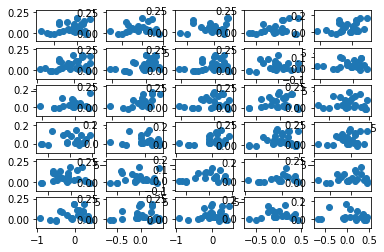

In [221]:
plot_days_shift(moving_avg(intel_delta_price, 5), moving_avg(intel_pol, 14), days_low=1, days_high=31)

In [223]:
get_r2(moving_avg(intel_delta_price, 5), moving_avg(intel_pol, 7), days_high = 60)

1 0.0692370999575
2 0.00292630356143
3 0.150028390603
4 0.163139311703
5 0.18649860431
6 0.261831984522
7 0.140937805026
8 0.111541279159
9 0.100169255114
10 0.06713216467
11 0.13475380478
12 0.25006048478
13 0.149582464663
14 0.0537918099092
15 0.00103872233047
16 0.153754125364
17 0.01881471589
18 0.251972453517
19 0.0584090452004
20 0.106193016538
21 0.0717441556634
22 0.0636179707225
23 0.0387051611296
24 0.0452843409025
25 0.0548280309326
26 0.115855158901
27 0.0336101854955
28 0.110856178845
29 0.00230709295007
30 0.0169214914527
31 0.00379919638712
32 0.269757544466
33 0.102712187449
34 0.111685422121
35 0.0797493570373
36 0.0106839825813
37 0.000893449767846
38 0.191759190588
39 0.186391913402
40 0.0718802192396
41 0.0143672306371
42 0.0306062516011
43 0.0605815479169
44 0.0124673992494
45 0.00168432401415
46 0.00557435885573
47 0.0460579928622
48 0.143380054881
49 0.00802671342029
50 0.0249842582732
51 0.0548135571706
52 0.156038954034
53 0.0500925699682
54 0.204797534177
55 0

## 3.10 working with comment polarity

### 3.10.1 get comment polarity

In [203]:
amd_comm, amd_score = get_comments_by_date(amd_com, '2017-10-01', '2019-02-01')

amd_comm_df = get_polarity(amd_comm)

amd_comm_df.head(n=3)

amd_comm_pol = amd_comm_df['polarity'].sort_index()

In [207]:
get_r2(moving_avg(amd_delta_price, 5), moving_avg(amd_comm_pol, 7), days_high = 60)

1 0.00422873507202
2 0.0246678310128
3 0.095833257568
4 0.223647963097
5 0.0797207419694
6 0.0158328668392
7 0.00332383956061
8 0.0182542301039
9 0.0471628105458
10 0.0109423141554
11 0.00150972985372
12 0.00809341491257
13 0.0322009713512
14 0.00058004326567
15 0.0347706413735
16 0.0125134884581
17 0.0178998624775
18 0.00174965982128
19 0.0238175413804
20 0.000945441841583
21 0.0202304643828
22 0.00542913700362
23 0.0129336525887
24 0.0207942262813
25 0.00709820769531
26 0.0202999360706
27 0.0277958285889
28 0.168896067231
29 0.164706659473
30 0.0308629833546
31 0.000176527548353
32 0.00360906152643
33 0.00622619321282
34 0.000678149698627
35 0.0502063148084
36 0.0144462475774
37 0.002772003744
38 0.0316135979175
39 0.0196021619919
40 0.0227120427358
41 0.000209767342492
42 0.00849740309642
43 0.000292583086902
44 0.0390888501004
45 0.0445489120171
46 0.0144482493442
47 0.00132922709456
48 0.000218611139534
49 0.012010808154
50 0.00495207219312
51 0.000164101020809
52 0.00297091295933

In [208]:
intel_comm, intel_score = get_comments_by_date(intel_com, '2017-10-01', '2019-02-01')

intel_comm_df = get_polarity(intel_comm)

intel_comm_df.head(n=3)

intel_comm_pol = intel_comm_df['polarity'].sort_index()

intel_delta_price = get_stock_delta_price('intel_stock.pkl', '2017-10-01', '2019-02-01')

In [211]:
get_r2(moving_avg(intel_delta_price, 5), moving_avg(intel_comm_pol, 14), days_high = 60)

1 0.140170541045
2 0.139561814727
3 0.124922619158
4 0.132495260444
5 0.22163787327
6 0.180860237435
7 0.179974485854
8 0.240026543612
9 0.202305933736
10 0.260681014105
11 0.121891631048
12 0.166264195657
13 0.126024690654
14 0.157183984905
15 0.135886037523
16 0.252086904655
17 0.132933024228
18 0.195199740967
19 0.125279076506
20 0.28871264412
21 0.152234755226
22 0.158716382167
23 0.157911302037
24 0.134702667368
25 0.223453438015
26 0.191224214828
27 0.207395348607
28 0.188666445062
29 0.170540813288
30 0.111099328329
31 0.101650433116
32 0.130162288981
33 0.173940666585
34 0.121307536044
35 0.0999535228594
36 0.0743934465135
37 0.0242971632487
38 0.0489687569635
39 0.0447399457865
40 0.0589687685311
41 0.0568542732319
42 0.0270448040023
43 0.0494115788183
44 0.0425237668462
45 0.0400423048808
46 0.0144028839667
47 0.0488539706411
48 0.0340448182257
49 0.0205607853935
50 0.0375179191912
51 0.091353843228
52 0.0669268862576
53 0.099408751125
54 0.0819946152245
55 0.06228041351
56 0

# 4. predict

## 4.1 prepare train & testing set

In [693]:
def rolling(a, window):
    shape = (a.size - window + 1, window)
    strides = (a.itemsize, a.itemsize)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

#a = np.arange(10)
#print rolling(a, 3)

In [722]:
x_train = rolling(amd_sub_df['polarity'][:168], 7)
y_train = rolling(amd_stock[116:284],7)

x_test = rolling(amd_sub_df['polarity'][168:184], 7)
y_test = rolling(amd_stock[284:],7)

## 4.2 model and predict

In [842]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
  
rgr = MultiOutputRegressor(GradientBoostingRegressor(random_state=0))
rgr.fit(x_train, y_train)
y_pred2 = rgr.predict(x_test)

In [770]:
def pad_vec(vec, positions):
    # positions is list of indexes to pad the vector
    for n in positions:
        vec = np.insert(vec, n, 0) 
    return vec

# pad_vec(np.array([1,2,3,4,5]), [0,1,2,8])
# array([0, 0, 0, 1, 2, 3, 4, 5, 0])

In [819]:
def get_avg_ypred(y_pred):
    
    arr_len = len(y_pred[0])
    arr_wid = y_pred.shape[0]
    
    final_len = arr_len+arr_wid -1
    final = np.zeros(final_len,)

    leading_zeros = 0
    ending_zeros = arr_wid-1

    count_values = np.zeros(final_len,)
    
    result = []
    
    def f(n):
        return 1 if n>0 else 0

    for vec in y_pred:

        pos = list(range(0,leading_zeros))+list(range(arr_len+leading_zeros,final_len))
        vec = pad_vec(vec, pos)
        leading_zeros += 1
        ending_zeros += 1
        # print vec
        final += vec
        count_values += np.array(map(f, vec))
        
    for i in range(final_len):
        val = final[i]/float(count_values[i])
        result.append(val)
    
    return result
    
    

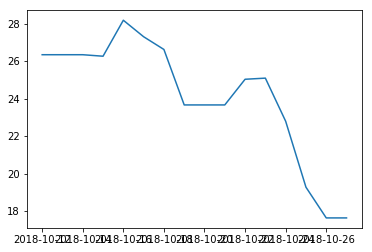

In [834]:
#plt.plot(get_avg_ypred(y_pred))
plt.plot(amd_stock[284:])

In [846]:
test_index = amd_stock[284:].index

In [850]:
predicted_stock = pd.Series(get_avg_ypred(y_pred))

In [851]:
predicted_stock.index=test_index

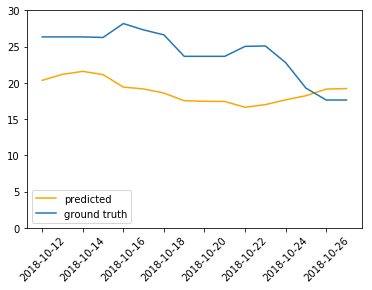

In [892]:
plt.figure()
axes = plt.gca()
axes.set_ylim([0,30])
plt.xticks(rotation=45)

plt.plot(predicted_stock, label= 'predicted', color = 'orange')
plt.plot(amd_stock[284:], label='ground truth')
plt.legend(loc='best')
plt.show()

In [860]:
from scipy.stats import pearsonr

pearsonr(amd_stock[284:], predicted_stock)

(0.2640976840832782, 0.3229590585745307)

## 4.3 ARIMA

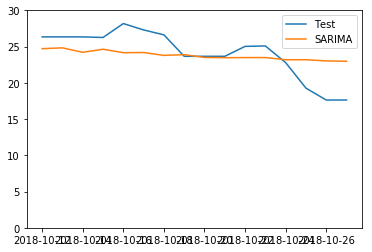

In [914]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

y_hat_avg = amd_stock[284:]
fit1 = SARIMAX(amd_stock[92:284], order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2018-10-12", end="2018-10-27", dynamic=True)
plt.figure()
#plt.plot( amd_stock[:284], label='train')
axes = plt.gca()
axes.set_ylim([0,30])
plt.plot(amd_stock[284:], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()


In [916]:
pearsonr(amd_stock[284:], y_hat_avg['SARIMA'])

(0.7835243149808842, 0.000329678900440087)

## 4.4 compare

<Figure size 600x400 with 0 Axes>

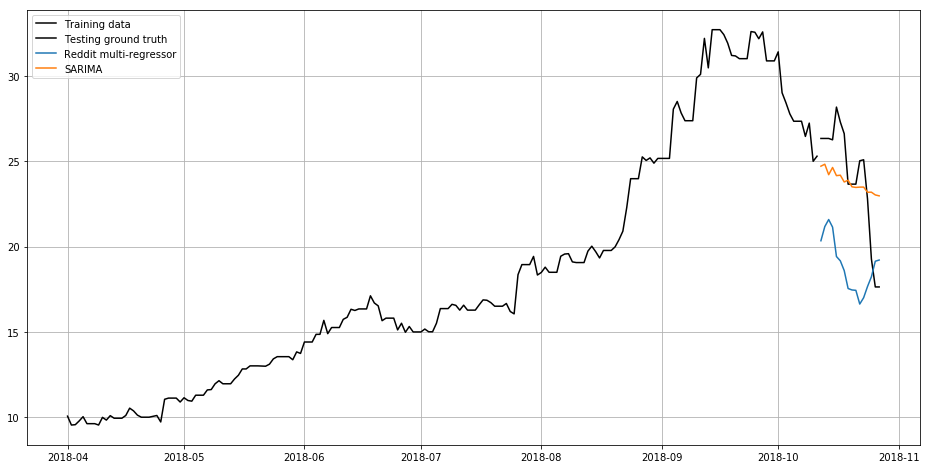

In [915]:
plt.figure()
#axes = plt.gca()
#axes.set_ylim([0,35])
plt.figure(figsize=(16,8))
plt.plot( amd_stock[90:284], label='Training data', color='black')
plt.plot(amd_stock[284:], label='Testing ground truth', color='black')
plt.plot(predicted_stock , label='Reddit multi-regressor')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.grid()
plt.show()

In [922]:
from math import sqrt
from sklearn.metrics import mean_squared_error

print sqrt(mean_squared_error(amd_stock[284:], y_hat_avg.SARIMA))
print sqrt(mean_squared_error(amd_stock[284:], predicted_stock))


2.78663839615
6.13545591416


<a id='section_5'></a>

# 5. conclusion

- pearson correlation:
    - Reddit multi-regressor predictions showed lower correlation coefficient
    
- RMSE 
    - Reddit multi-regressor showed higher error
    

- possible reasons:
    - Reddit multi-regressor tries to predict stock price well ahead of time 
    - ARIMA used more data than Reddit Muti-Regressor - ARIMA failed to converge when same training set was fed into it, so more training data was used to train that model
    - Reddit input data sparse
    - different rolling window
    - more training data 
    
- future improvements:
    - use different type of model
    - use a better sentiment analyzer 
    - Reddit text relevance
    - Reddit text clean up - profanity isn't always negative sentiment
    - add more features: comments polarity, total score
    